# Tracking 3D object by their centroids

In [1]:
%pip install -q --upgrade -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Importing packages

`laptrack.LapTrack` is the core object for tracking.

In [2]:
import napari
import numpy as np
import pandas as pd
from skimage.measure import regionprops_table
from matplotlib import pyplot as plt

from laptrack import LapTrack
from laptrack import datasets
from laptrack import data_conversion

## Loading images and showing them in napari

In [3]:
viewer = napari.Viewer(ndisplay=3)
images, labels = datasets.HL60_3D_synthesized()
viewer.add_image(images)
viewer.add_labels(labels)

<Labels layer 'labels' at 0x141eac920>

# Calculate centroids of the labels

In [4]:
dfs = []
for frame, l in enumerate(labels):
    dfs.append(
        pd.DataFrame(regionprops_table(l, properties=["label", "centroid"])).assign(
            frame=frame
        )
    )
regionprops_df = pd.concat(dfs, ignore_index=True)
regionprops_df.rename(
    columns={"centroid-0": "z", "centroid-1": "y", "centroid-2": "x"}, inplace=True
)
regionprops_df.head()

,label,z,y,x,frame
0,3,8.576642,28.700730,46.386861,0
1,4,8.557971,26.311594,53.833333,0
2,5,9.209524,28.704762,33.990476,0
3,7,8.666667,34.642276,38.333333,0
4,9,8.830189,25.452830,17.273585,0


In [5]:
viewer.add_points(
    regionprops_df[["frame", "z", "y", "x"]],
    size=2,
    name="centroid",
    blending="additive",
)

<Points layer 'centroid' at 0x143bc6420>

2025-07-25 11:44:47.717 python[99038:605241] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (1.14 secs).


# Track centroid

First, initialize the `LapTrack` object with parameters. 

In [6]:
max_distance = 15
lt = LapTrack(
    metric="sqeuclidean",  # The similarity metric for particles. See `scipy.spatial.distance.cdist` for allowed values.
    splitting_metric="sqeuclidean",  # The similarity metric for splits.
    # the square of the cutoff distance for the "sqeuclidean" metric
    cutoff=max_distance**2,
    gap_closing_cutoff=max_distance**2,
    splitting_cutoff=max_distance**2,
)

In [ ]:
track_df, split_df, merge_df = lt.predict_dataframe(
    regionprops_df,
    coordinate_cols=["z", "y", "x"],  # the column names for the coordinates
    frame_col="frame",  # the column name for the frame (default "frame")
)
track_df = track_df.reset_index()

- track_id : unique ID for each track
- tree_id : unique ID for each "clonal" set of track (track sharing the same ancestor)

In [8]:
track_df.head()

,index,label,z,y,x,frame,tree_id,track_id
0,0,3,8.576642,28.700730,46.386861,0,0,0
1,1,4,8.557971,26.311594,53.833333,0,1,1
2,2,5,9.209524,28.704762,33.990476,0,2,2
3,3,7,8.666667,34.642276,38.333333,0,3,3
4,4,9,8.830189,25.452830,17.273585,0,4,4


In [9]:
graph = data_conversion.split_merge_df_to_napari_graph(split_df, merge_df)
viewer.add_tracks(track_df[["track_id", "frame", "z", "y", "x"]], graph=graph)

<Tracks layer 'Tracks' at 0x15b998e60>

([], [])

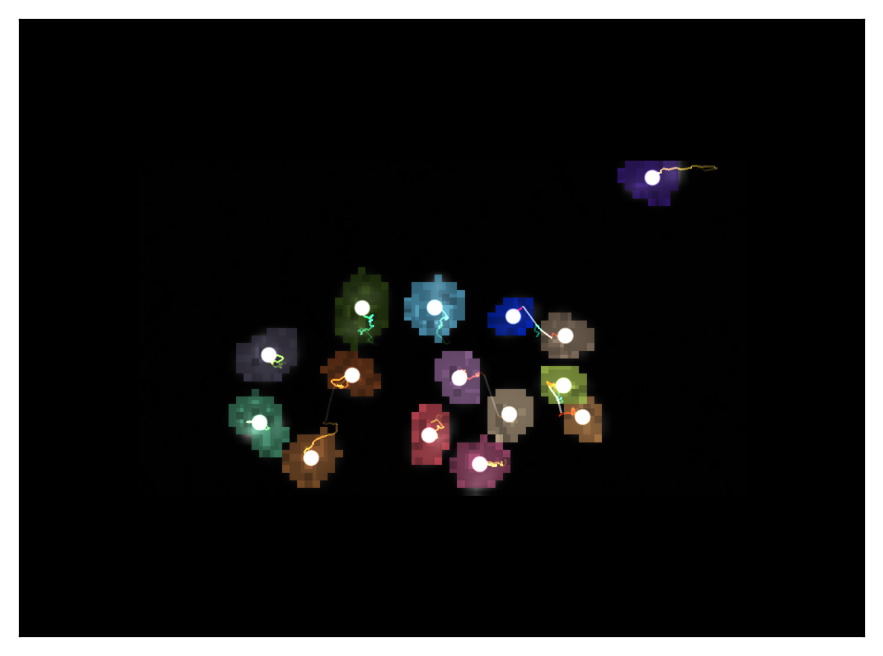

In [10]:
viewer.dims.current_step = (74, 0, 0, 0)
plt.imshow(viewer.screenshot())
plt.xticks([])
plt.yticks([])